## Comparative analysis of Adaptive sampling and Control on R9, R10 and Playback


In [3]:
from itertools import zip_longest
from pathlib import Path

print(Path().cwd())
from string import ascii_uppercase

import matplotlib.font_manager as font_manager
import matplotlib.image as img
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import EngFormatter

/home/adoni5/Projects/Chapter_1_Data/chr20_21_experiment


/home/adoni5/mambaforge/envs/jupyter-lab/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
plt.style.use("../dotfiles-rm/thesis/thesis.mplstyle")
font_dir = "../dotfiles-rm/"
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
sns.set_palette("colorblind")
rcParams["font.family"] = "Roboto"

In [5]:
PAF_FILES = [
    (
        "playback_paf_files/adaptive_icarust_playback.paf",
        "Playback",
        "Adaptive",
    ),
    (
        "playback_paf_files/control_icarust_playback.paf",
        "Playback",
        "Control",
    ),
    ("R9_paf_files/control_icarust_R9.paf", "Icarust R9", "Control"),
    (
        "R9_paf_files/adaptive_icarust_R9.paf",
        "Icarust R9",
        "Adaptive",
    ),
    (
        "R10_paf_files/control_icarust_R10.paf",
        "Icarust R10",
        "Control",
    ),
    (
        "R10_paf_files/adaptive_icarust_R10.paf",
        "Icarust R10",
        "Adaptive",
    ),
]
with open("hg38_contig_to_human_readable.txt") as fh:
    CONTIG_LOOKUP = dict([line.split()[::-1] for line in fh])

In [6]:
def median_read_length(group: pd.DataFrame) -> int:
    """
    Returns the median read length for a given group
    """
    return group["read_length"].median()


def total_yield(group: pd.DataFrame) -> float:
    """
    Returns the total yield for a given group
    """
    return group["read_length"].sum()


def yield_ratio(group: pd.DataFrame) -> float:
    """
    c Yield ratio for the adaptive divided by the control
    """
    adaptive_yield = group[group["Condition"] == "Adaptive"]["read_length"].sum()
    control_yield = group[group["Condition"] == "Control"]["read_length"].sum()
    return adaptive_yield / control_yield

In [7]:
dfs = []
for paf, generation_method, condition in PAF_FILES:
    df_paf = pd.read_csv(
        paf,
        sep="\t",
        header=None,
        names=[
            "read_id",
            "read_length",
            "strand",
            "contig",
            "contig_length",
            "map_start",
            "map_end",
            "map_q",
        ],
        usecols=[0, 1, 4, 5, 6, 7, 8, 11],
    )
    df_paf["Simulation method"] = generation_method
    df_paf["Condition"] = condition
    dfs.append(df_paf)
df = pd.concat(dfs)
df = df.sort_values(["contig", "Condition"])
df["Chromosome"] = df["contig"].map(CONTIG_LOOKUP)

value_dfs = []
values_types = ["Median read length", "Yield", "Yield ratio"]
aggregator = dict(zip(values_types, (median_read_length, total_yield, yield_ratio)))
groups = (
    ["Simulation method", "Condition", "Chromosome"],
    ["Simulation method", "Condition", "Chromosome"],
    ["Simulation method", "Chromosome"],
)
group_bys = dict(zip_longest(values_types, groups))
for value in values_types:
    value_df = df.copy()
    group = group_bys[value]
    value_df = value_df.set_index(group)
    # calculate the median, yield ratio and yield
    value_df["value"] = value_df.groupby(group).apply(aggregator[value])
    value_df = value_df.reset_index()
    value_df["value_type"] = value
    value_dfs.append(value_df)

value_df = pd.concat(value_dfs)
# remove the control column for the yield ratio, as it is always one.
value_df = value_df[
    ~((value_df["value_type"] == "Yield ratio") & (value_df["Condition"] == "Control"))
]

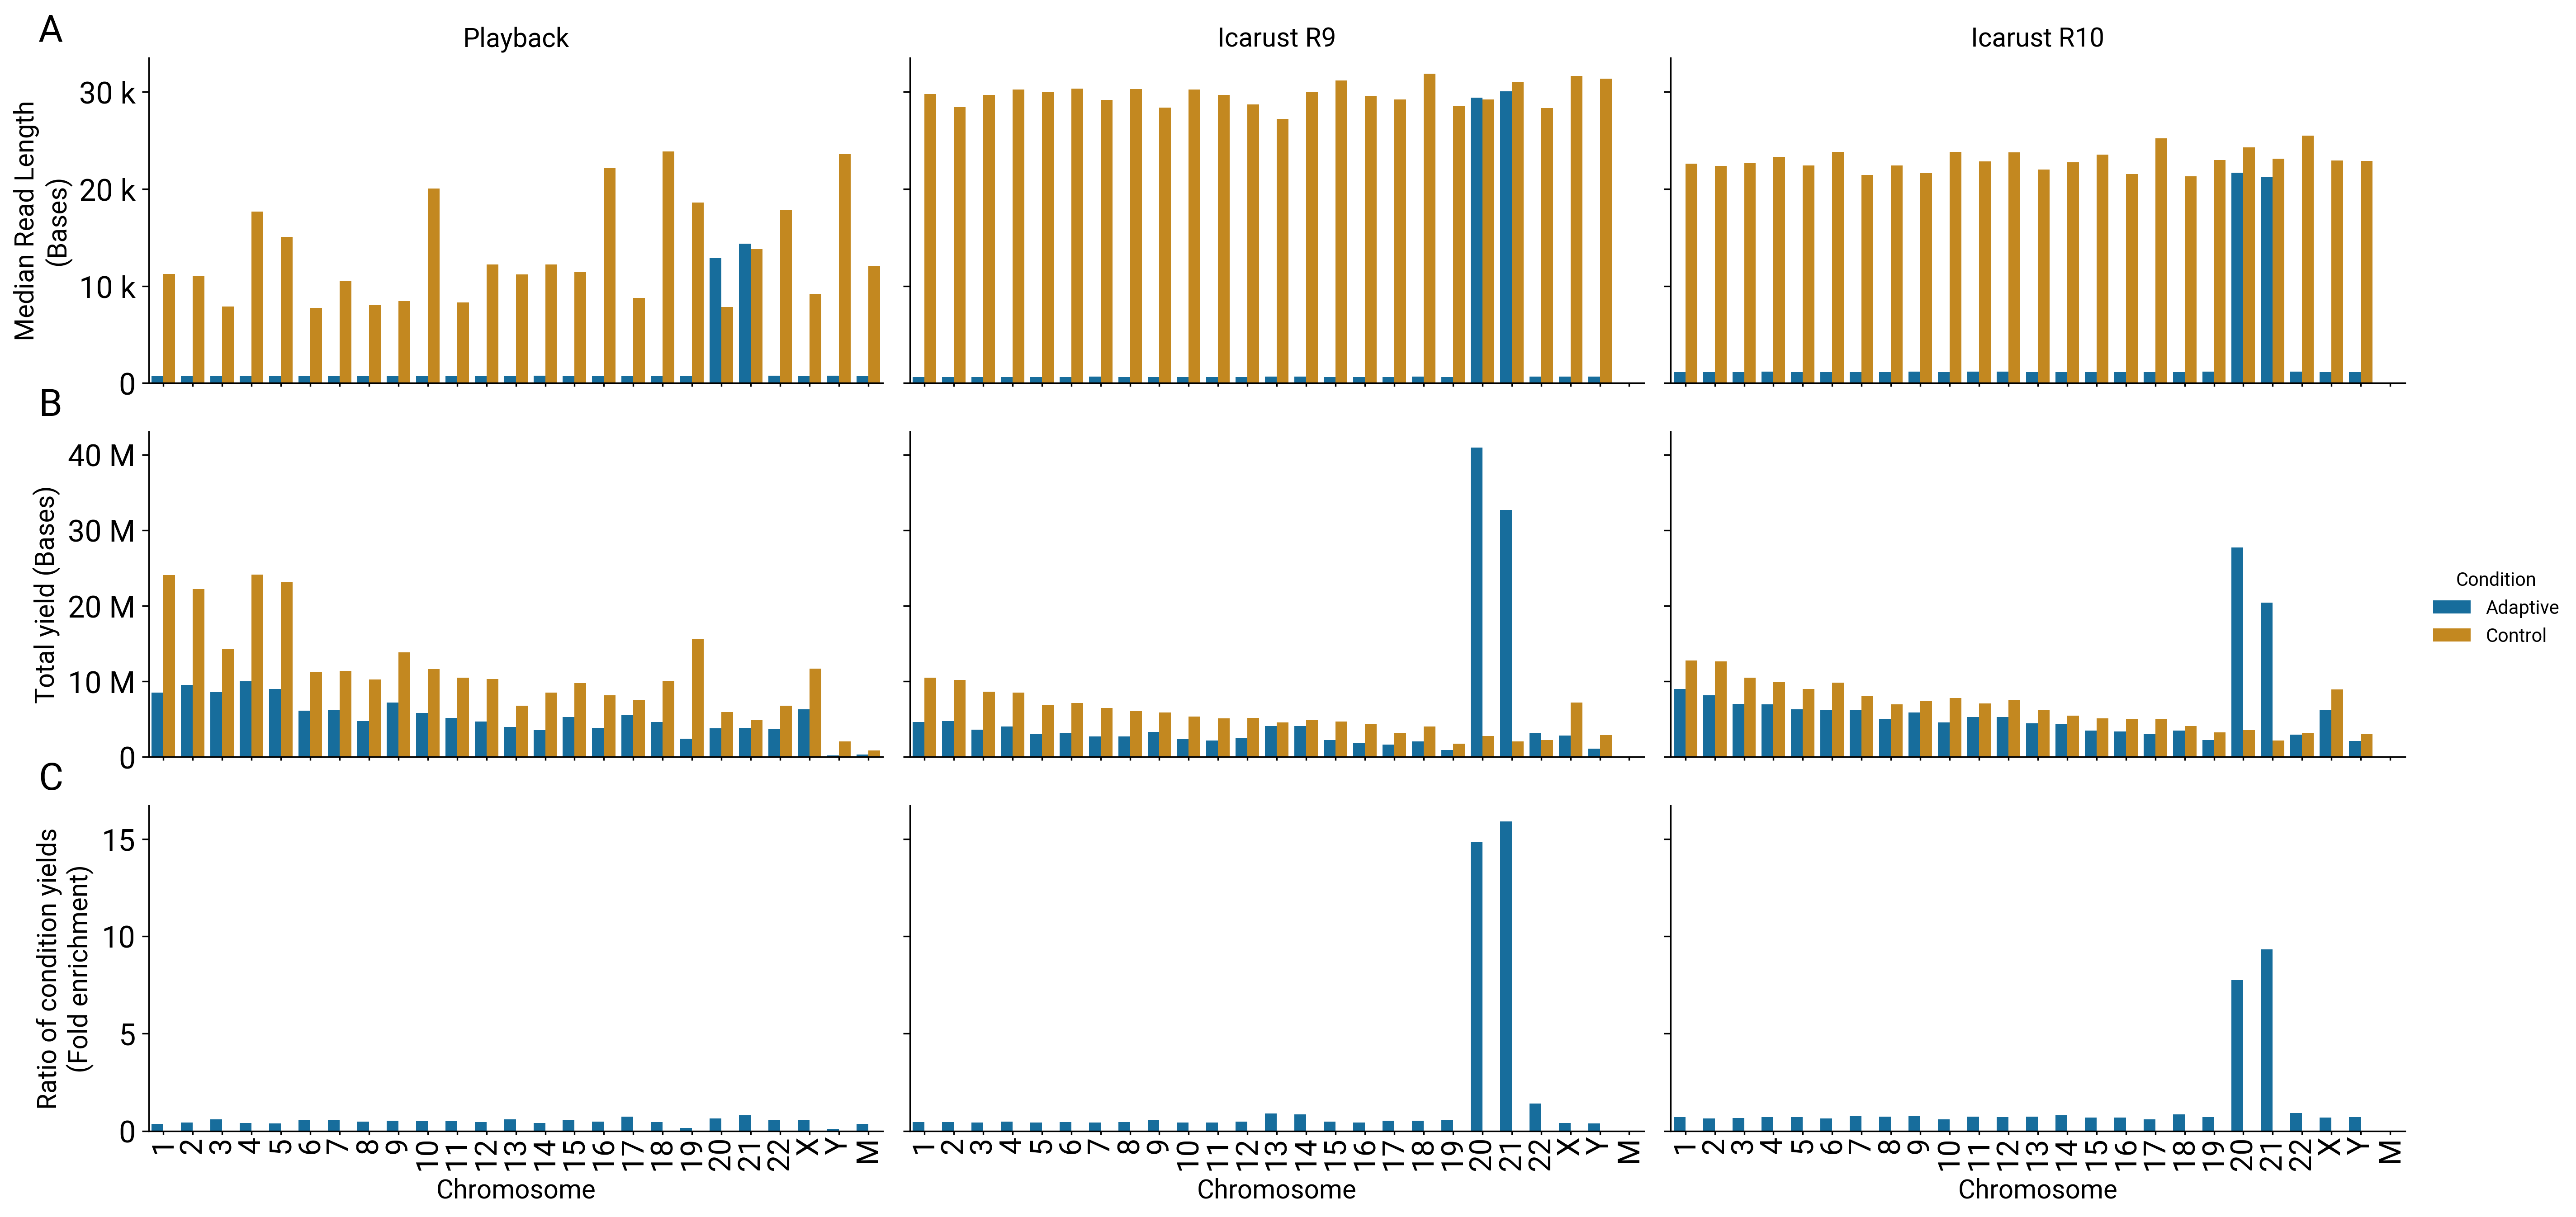

In [8]:
g = (
    sns.catplot(
        data=value_df,
        errorbar=None,
        col="Simulation method",
        row="value_type",
        hue="Condition",
        x="Chromosome",
        kind="bar",
        y="value",
        # aspect=2.3,
        sharey="row",
        height=3,
        aspect=2,
    )
    .tick_params(rotation=90, axis="x", pad=1.1, length=1.8)
    .set_titles(template="{col_name}")
)
axes = g.axes.flatten()
# Sigh, there has to be a way to do this in seaborn
y_labels = (
    "Median Read Length\n(Bases)",
    "Total yield (Bases)",
    "Ratio of condition yields\n(Fold enrichment)",
)
for ind, ax in enumerate(axes):
    if ind < 4:
        ax.xaxis.label.set_visible(False)
    else:
        ax.set_xlabel(ax.xaxis.get_label_text(), fontsize=14)
    # change yaxis font size
    ax.set_ylabel(ax.yaxis.get_label_text(), fontsize=14)
    # Add figure row labels
    if ind in {0, 3, 6}:
        ax.text(
            -0.15, 1.05, ascii_uppercase[ind // 3], transform=ax.transAxes, fontsize=20
        )
    # Remove the axes titles for second and third rows
    if ind > 2:
        ax.title.set_visible(False)
    ax.yaxis.set_major_formatter(EngFormatter())
    ax.set_ylabel(y_labels[ind // 3])
plt.subplots_adjust(hspace=0.15)

In [9]:
g.savefig("Icarust_chr20_21_sim.svg", bbox_inches="tight", dpi=350)

# Table of all the yields for the experiments


In [28]:
def format_bases(num: int, factor: int = 1000, suffix: str = "B") -> str:
    """Return a human readable string of a large number using SI unit prefixes

    :pararm num: A number to convert to decimal form
    :param factor: The SI factor, use 1000 for SI units and 1024 for binary multiples
    :param suffix: The suffix to place after the SI prefix, for example use B for SI units and iB for binary multiples
    :return: The input number formatted to two decimal places with the SI unit and suffix

    :Example:

    >>> format_bases(1_000)
    '1.00 kB'
    >>> format_bases(1_000_000)
    '1.00 MB'
    >>> format_bases(1_630_000)
    '1.63 MB'
    >>> format_bases(1_000_000_000)
    '1.00 GB'
    """
    for unit in ["", "k", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < factor:
            return f"{num:3.2f} {unit}{suffix}"
        num /= factor
    return f"{num:3.2f} Y{suffix}"

In [34]:
yields_df = df.groupby(["Simulation method", "Condition"])[["read_length"]].sum()
yields_df = yields_df.rename(columns={"read_length": "Yield"})
yields_df["Yield"] = yields_df["Yield"].apply(format_bases)
print(
    yields_df.style.to_latex(
        siunitx=True,
        hrules=True,
        caption=("The sequencing yields for the simulation runs performed to compare play back with Icarust simulations, rounded to the nearest \num{100} nucleotide bases.", "Sequencing yields for simulation runs"),
        label="tab:icarust-chr20-yields",
    )
)

\begin{table}
\caption[short caption]{Full caption}
\label{tab:icarust-chr20-yields}
\begin{tabular}{lll}
\toprule
{} & {} & {Yield} \\
{Simulation method} & {Condition} & {} \\
\midrule
\multirow[c]{2}{*}{Icarust R10} & Adaptive & 159.98 MB \\
 & Control & 164.70 MB \\
\multirow[c]{2}{*}{Icarust R9} & Adaptive & 136.75 MB \\
 & Control & 130.80 MB \\
\multirow[c]{2}{*}{Playback} & Adaptive & 133.19 MB \\
 & Control & 286.09 MB \\
\bottomrule
\end{tabular}
\end{table}

